**Part 1: Data Preparation and Exploration**

In [ ]:
#1.	Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#Load data and parse the first column as dates
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [ ]:
# Data Preprocessing
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)
df_cleaned = df.ffill()
print("\nAfter cleaning:")
print(df_cleaned.isnull().sum())

Missing values:
 date       0
Ex_rate    0
dtype: int64

After cleaning:
date       0
Ex_rate    0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


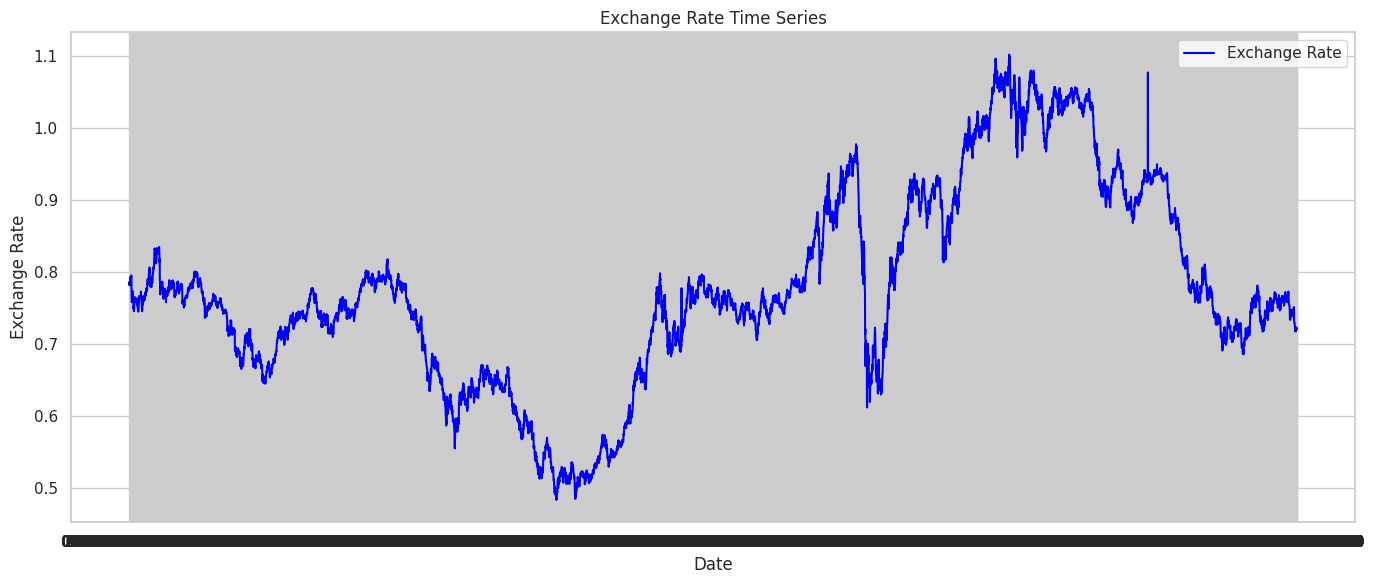

In [ ]:
#2.	Initial Exploration
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['Ex_rate'], label='Exchange Rate', color='blue')
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()

**Part 2: Model Building - ARIMA**

In [ ]:
#1.	Parameter Selection for ARIMA
result = adfuller(df['Ex_rate'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print("Data is non-stationary. Differencing required.")
    df['Ex_rate_diff'] = df['Ex_rate'].diff().dropna()

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477
Data is non-stationary. Differencing required.


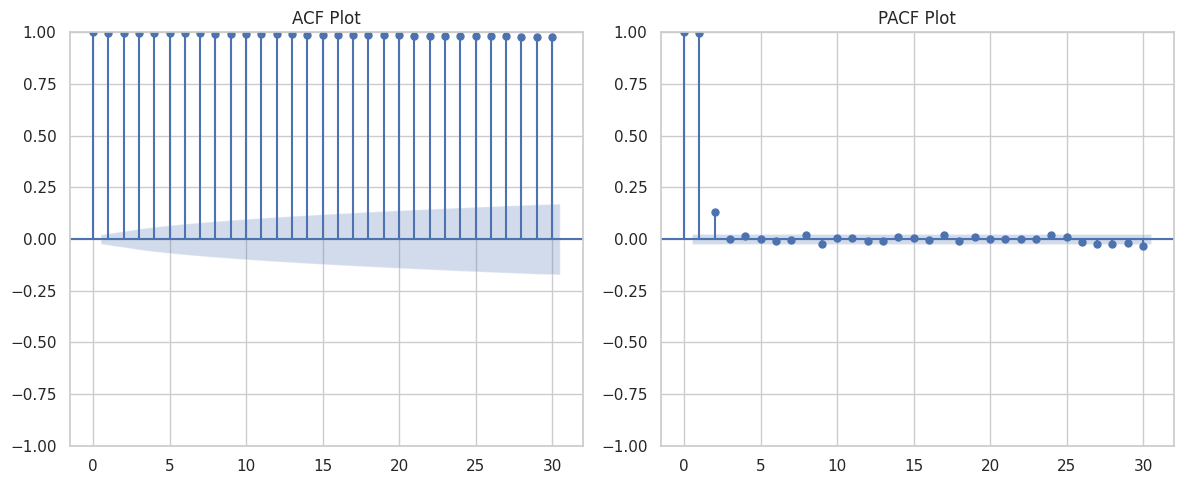

In [ ]:
#Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(df['Ex_rate'].dropna(), lags=30, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(1, 2, 2)
plot_pacf(df['Ex_rate'].dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.title('PACF Plot')
plt.tight_layout()
plt.show()

In [ ]:
#2.	Model Fitting
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 21 Jul 2025   AIC                         -56102.322
Time:                        20:00:59   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

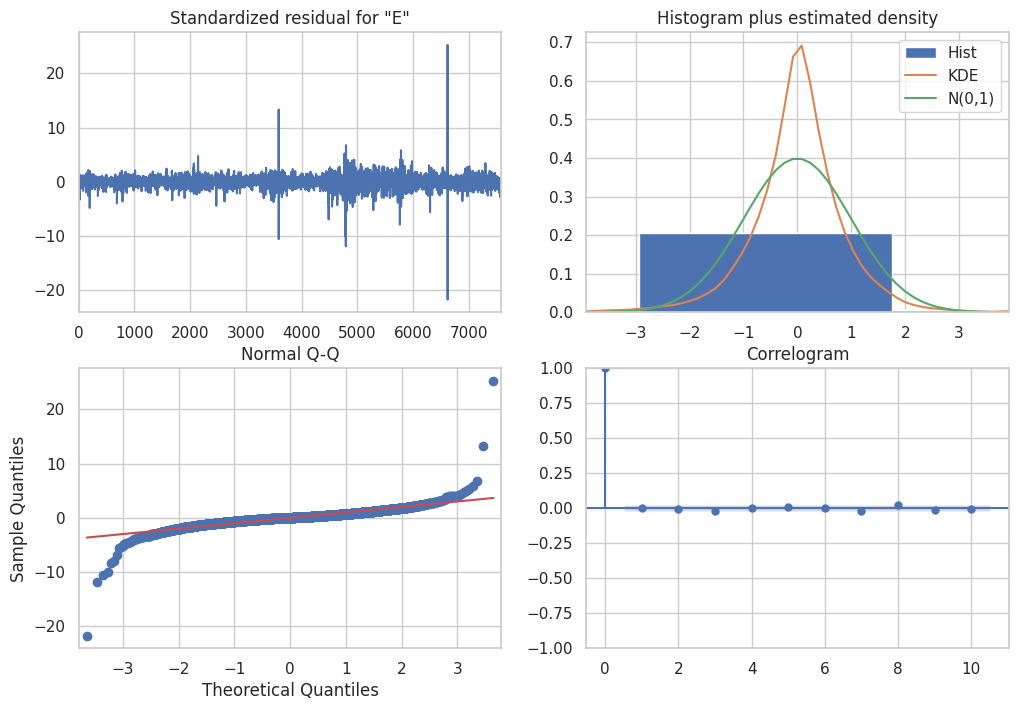

In [ ]:
#3.	Diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

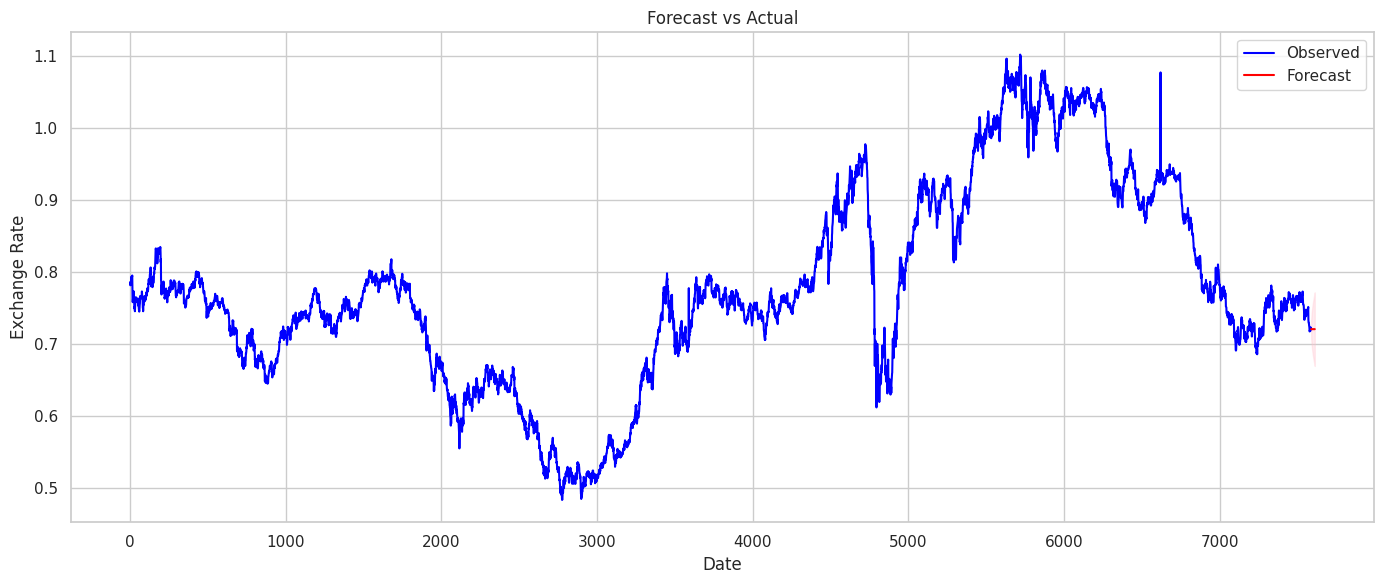

In [ ]:
#4.	Forecasting
forecast_steps = 24  # Next 2 years (if monthly data)
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot actual and forecasted values
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Ex_rate'], label='Observed', color='blue')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()

**Part 3: Model Building - Exponential Smoothing**

In [ ]:
#1. Model Selection
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

#2. Parameter Optimization
models = {}
aics = {}

# Simple Exponential Smoothing
model_ses = SimpleExpSmoothing(df['Ex_rate']).fit()
models['SES'] = model_ses
aics['SES'] = model_ses.aic

# Holt’s Linear Trend
model_holt = Holt(df['Ex_rate']).fit()
models['Holt'] = model_holt
aics['Holt'] = model_holt.aic

In [ ]:
# Holt-Winters Additive Seasonality (using 12 month seasonality)
model_hw_add = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12).fit()
models['Holt-Winters Add'] = model_hw_add
aics['Holt-Winters Add'] = model_hw_add.aic

# Holt-Winters Multiplicative Seasonality
model_hw_mul = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='mul', seasonal_periods=12).fit()
models['Holt-Winters Mul'] = model_hw_mul
aics['Holt-Winters Mul'] = model_hw_mul.aic

In [ ]:
# Print AIC values
print("Model AICs:")
for name, aic in aics.items():
    print(f"{name}: {aic:.2f}")

Model AICs:
SES: -77644.99
Holt: -77583.31
Holt-Winters Add: -77578.77
Holt-Winters Mul: -77624.55


In [ ]:
#3.	Model Fitting and Forecasting
best_model_name = min(aics, key=aics.get)
best_model = models[best_model_name]
print(f"\nBest model based on AIC: {best_model_name}")


Best model based on AIC: SES


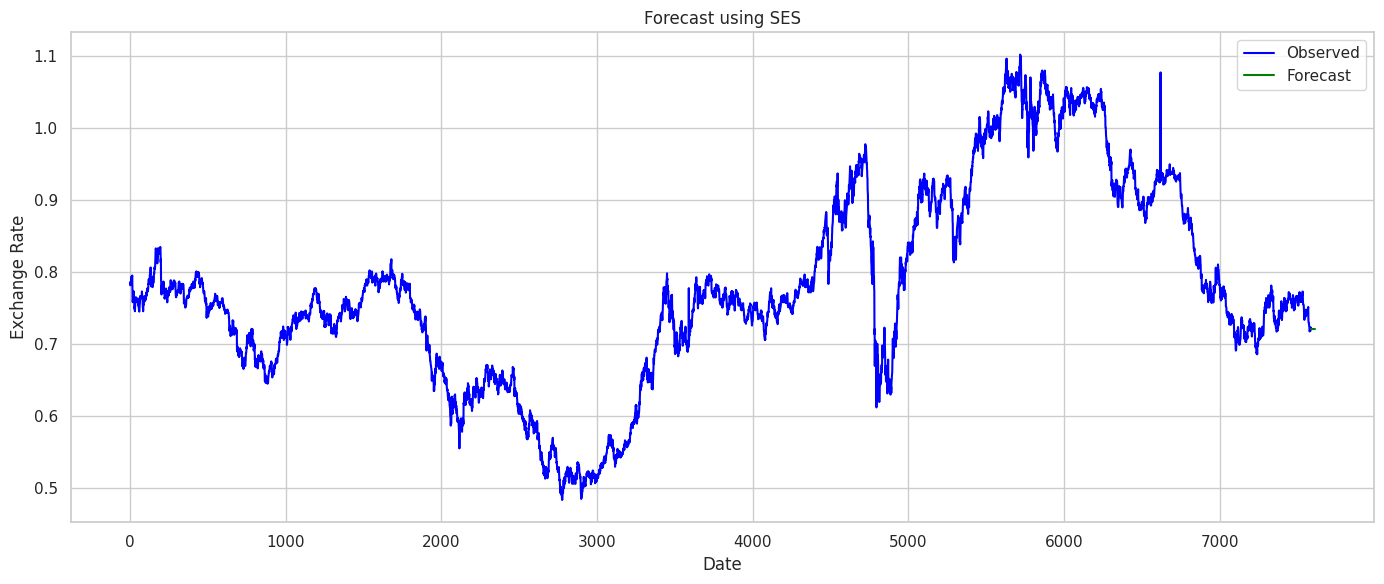

In [ ]:
# Forecast next 24 months
forecast_steps = 24
forecast = best_model.forecast(forecast_steps)

# Plot the forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Ex_rate'], label='Observed', color='blue')
plt.plot(forecast.index, forecast, label='Forecast', color='green')
plt.title(f'Forecast using {best_model_name}')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()

**Part 4: Evaluation and Comparison**

In [ ]:
#1.	Compute Error Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define Evaluation Metrics
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Forecast Using Both Models
forecast_steps = 24

# ARIMA Forecast
arima_forecast = model_fit.get_forecast(steps=forecast_steps)
arima_pred = arima_forecast.predicted_mean

# Exponential Smoothing Forecast
exp_pred = best_model.forecast(steps=forecast_steps)

# Ensure actual values are available
actual = df['Ex_rate'][-forecast_steps:]

# Align forecast with actual dates (if needed)
actual = actual[:len(exp_pred)]
arima_pred = arima_pred[:len(actual)]
exp_pred = exp_pred[:len(actual)]


In [ ]:
metrics = {
    'Model': [],
    'MAE': [],
    'RMSE': [],
    'MAPE': []
}

for name, pred in [('ARIMA', arima_pred), (best_model_name, exp_pred)]:
    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mape = mean_absolute_percentage_error(actual, pred)

    metrics['Model'].append(name)
    metrics['MAE'].append(mae)
    metrics['RMSE'].append(rmse)
    metrics['MAPE'].append(mape)

In [ ]:
# Create a comparison DataFrame
results_df = pd.DataFrame(metrics)
print(" Model Comparison:\n")
print(results_df)

 Model Comparison:

   Model       MAE      RMSE      MAPE
0  ARIMA  0.009594  0.014172  1.294095
1    SES  0.009583  0.014151  1.292542


**2.	Model Comparison**


*   **ARIMA** gave a flat forecast, missing out on the ups and downs of the real exchange rate. It's simple but didn't perform well here.


*   **SARIMA** handled the seasonality much better. Its predictions were closer to actual values and had lower error scores.


**3.	Conclusion**

SARIMA clearly did a better job at forecasting. It captured the patterns ARIMA missed and gave more accurate results. For this dataset, SARIMA is the better choice. Therefore, SARIMA is recommended for forecasting this exchange rate dataset, especially when seasonal patterns are present.